In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines() #split the names be line
words[:8] #get the 1st 8 names

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words) #total no. of names

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
#join the names together into one long list, '' empty string is used in between the names when joiing
#set only extract the unique chars in this long list of joined names
#list converts it back into a list type
#sorted sorts the chars from a-z
chars = sorted(list(set(''.join(words)))) # chars is a list of unique characters starting with a-z
#curley braces create a dictionary
#enumerate(chars): pairs each character in the chars list with its corresponding index
#assign index i+1 to the char s in the dictionary. Starts at 1 to leave space at 0 index for special char
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 #special char '.' at 0
itos = {i:s for s,i in stoi.items()} #create a reverse mapped dictionary of index, char pairs in itos (rather than char, index pairs in stoi)
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [47]:
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [ ]:
# build the dataset
# the data is a list of arrays, each of size block_size (3 in this case)
# 'emm' = [5, 13, 13]

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] # X is the input data, Y is the target data. Datatypes are lists
for w in words: # for each name in the list of names
  
  #print(w)
  #context always has the length of blocksize, and starts with 3 special chars at the beginning of each name (index 0)
  context = [0] * block_size #if blocksize = 3, context = [0,0,0], this starts the name with 3 indexes of the starting special char '.'
  for ch in w + '.': #append special end char '.' to w, then char level loop will include it in the length of the word (for each char in the word + special char)
    ix = stoi[ch] #grab the index of the char from the dictionary
    X.append(context) #append the indexes in context created earlier to X. Every name starts with 3 0's, (index of special start chars)
    Y.append(ix) #append the char's index to Y so that for every context we have the next char's index stored in y
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # drop the 1st index in the current context and append the char's index in ix (sliding window)
  
X = torch.tensor(X) #store the pytorch list as a tensor for use in model training
Y = torch.tensor(Y)

In [6]:
#the 2nd context for the 1st name
#2 special start chars and 'e' the 6th char in the dictionary
X[1]

tensor([0, 0, 5])

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):   #this time defined the loop created before into a function
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42) #be able to recreate the randomized data
random.shuffle(words) #shuffle the order of the names in words
n1 = int(0.8*len(words)) #n1 contains an int that is 80% of the number of names in words
n2 = int(0.9*len(words)) #n2 contains an int that is 90% of the number of names in words

Xtr, Ytr = build_dataset(words[:n1]) #create a training dataset using only the 1st n1 (80%) of names in words
Xdev, Ydev = build_dataset(words[n1:n2]) #create a validation dataset using only the n1 to n2 (80-90%) of names in words
Xte, Yte = build_dataset(words[n2:]) #create a test dataset using only the final 10% of names in words (start index at n2 which is 90%)


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
#the inputs X
Xtr.shape

torch.Size([182625, 3])

In [11]:
C = torch.randn((27, 2)) #27 row x 2 col of rand vals
C

tensor([[ 0.7076,  0.6329],
        [-0.4068, -0.8468],
        [-0.9207,  1.8019],
        [ 0.3775, -0.4366],
        [ 0.7836,  0.7641],
        [-1.5797, -0.5166],
        [ 0.4721, -2.2854],
        [-0.2017, -0.2367],
        [-2.5230,  1.0077],
        [-0.1181, -0.0466],
        [-1.0559, -1.6669],
        [-1.3629, -0.5761],
        [-0.9497,  1.1321],
        [ 0.6094,  1.5725],
        [-0.3213,  0.2535],
        [-0.2320,  1.5291],
        [-1.1091, -0.3753],
        [ 1.4593,  0.7146],
        [-0.3234,  0.3552],
        [-0.5833,  0.2354],
        [ 0.4711, -1.6792],
        [-0.1131, -1.0825],
        [ 1.7369, -0.8804],
        [ 1.2876,  1.7021],
        [-0.4743, -2.5024],
        [ 0.7259,  1.5167],
        [ 1.3869,  1.0995]])

In [12]:
#example of what's happening at scale later
#[0,0,0] is the 1st input in X which is the 'e' char in emma, whith 2 special start chars before it
emb_test = C[[0,0,5]]
#passing it to C as addresses plucks out the 0th row, 0th row and 5th row as seen abave in the full C embedding array
emb_test

tensor([[ 0.7076,  0.6329],
        [ 0.7076,  0.6329],
        [-1.5797, -0.5166]])

In [13]:
#X = inputs to the model, which are sets of 3 ints, each representing the ID of the char
#this is repeating the process above, which we did for the 1st input, for all 228146 inputs
#for each of the 3 chars in a single input, the corresponding row of 2 values from C are plucked out
#Essentially the index of the char in X is replaced with the equivelant row of 2 values from C
emb = C[X] 
emb.shape

torch.Size([228146, 3, 2])

In [14]:
#a hidden layer of 6 x 100 (6 input weights per 100 neurons)
#6 is because after embedding, each of the 3 input chars is replaced with 2 values which results in 6 values total
#this value of 6 would increase if the context length increases or if the embedding matrix increases in size
#100 is a hyper-param of your choosing. Higher means more complex, but too hi could mean over-fitting
W1 = torch.randn((6, 100))
#a bias per neuron
b1 = torch.randn(100)

In [16]:
emb.view(-1, 6).shape #flatten the emb tensor into a 2D matrix of 228146 rows and 6 columns

torch.Size([228146, 6])

In [ ]:
# .view used to reshape the emb tensor. The -1 is a placeholder that means "whatever is needed to make the reshape work." 
#Here it's reshaping the tensor to have 6 cols, instead of 3 cols and depth 2
#instead of each of the 3 chars being a sub tensor of 2 embedding values, the whole context becomes a single 1D tensor of length 6
#this allows it to be multiplied by W1
# tanh is used to squash the output of the hidden layer to be between -1 and 1
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [20]:
h

tensor([[ 0.3473, -0.9935,  0.7665,  ..., -0.5674, -0.0068,  0.9456],
        [ 0.0541,  0.8823,  0.9690,  ..., -0.9997,  0.9926,  0.2454],
        [ 0.9673, -0.8733, -0.7180,  ..., -0.5782, -0.9961,  0.9952],
        ...,
        [ 0.8028, -0.9983,  0.9892,  ..., -0.9967, -0.7573,  0.9937],
        [-0.1219, -0.9989,  0.9940,  ..., -0.9891, -0.8377,  0.9937],
        [-0.9955,  0.7751,  0.9998,  ..., -0.9920,  0.9991, -0.5759]])

In [21]:
#The output of the hidden layer is a value for each of the weights for every context
#e.g. each context of 3 values (of which there are 228146) produces a value for every weight in the hidden layer
h.shape

torch.Size([228146, 100])

In [22]:
#the output layer, which receives an input for every neuron in the hidden layer (100 in this case)
#and has 27 neurons in total
W2 = torch.randn((100, 27))
#a bias value per neuron
b2 = torch.randn(27)

In [23]:
#multiply the output of the hidden layer with the output layer and add the bias vals
logits = h @ W2 + b2

In [24]:
#27 outputs per input context
logits.shape

torch.Size([228146, 27])

In [25]:
#exp to get the counts
counts = logits.exp()

In [26]:
#divide each val by the sum of the row to get a prob dist
#this uses broadcasting to divide each col by the same counts.sum val
prob = counts / counts.sum(1, keepdims=True)

In [27]:
prob.shape

torch.Size([228146, 27])

In [28]:
temp = torch.arange(32)
temp

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [29]:
#5 = e, which is the 1st char of emma. The 1st input in X is "..." which represent the start of a name
Y[0].item()

5

In [30]:
#torch.arrange is creating a 1D array of length 32 of values from 0-31 (as seen above)
#Y contains the actual char that comes next stored as an ID from the dictionary
#in this line, within each row in prob, the Y'th element is plucked out and nll calculated
#then the mean of this is calculated
loss = -prob[torch.arange(228146), Y].log().mean()
loss

tensor(20.4520)

In [31]:
# ------------ now made respectable :) ---------------

In [32]:
#Xtr inputs = 3 char context stored as IDs from the dictionary
#Ytr yargets = single char stored as IDs from the dict
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [ ]:
#all layers created as pytorch tensors
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# embeddings are a way of representing the input characters in a more compact form
C = torch.randn((27, 10), generator=g) #embeddings now increased to size 10 from 2. When multiplied by 3 chars (each one-hot encoded) this gives 30 inputs to the hidden layer
W1 = torch.randn((30, 200), generator=g) #input of 30 per neuron, as each of the 3 chars has 10 embedding vals. No. of neurons now 200
b1 = torch.randn(200, generator=g) #a bias val per neuron in the hidden layer
W2 = torch.randn((200, 27), generator=g) #200 inputs per neuron in the output layer. One for each neuron in the hidden layer
b2 = torch.randn(27, generator=g) #a bias val for for each neuron in the output layer
parameters = [C, W1, b1, W2, b2] #store all the layers in parameters for use in forward pass and back prop

In [34]:
#bias values in the hidden layer
b1.shape

torch.Size([200])

In [35]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [36]:
for p in parameters:
  p.requires_grad = True #require all params in the model to have a gradient val

In [37]:
#create a series of values for using learning rate decay. I.e steps of lr get smaller as lr gets smaller
#creates a 1D tensor of size 1000, with evenly spaced vals from -3 to 0
lre = torch.linspace(-3, 0, 1000)
#this creates a 1D list of values from 0-1 on an exp curve, where values increase in size close to 1
lrs = 10**lre

In [38]:
#look at the learning rate values if u wish
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [39]:
#places to store values that track the progress of the training after each iteration
lri = []
lossi = []
stepi = []

In [40]:
#a 1D tensor of length 32 with randon vals between 0 and 182625 (no. of rows in Xtr)
ix = torch.randint(0, Xtr.shape[0], (32,))
ix

tensor([138574,  46783, 141141, 169827,  24991, 116057,  84687, 115687,  64146,
        137520, 124671, 122805,  31193,  51402,  52099,   7346, 127845, 178391,
        147858,   9482, 138334, 156489,  22575,  81201,  40557,  69081, 135028,
         17995,  12917, 143729,  67377,  74040])

In [ ]:
#START HERE!!!!
gh = 0
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) #contains 32 random addresses for rows in the input (as shown above) to create a random batch of 32
  
  # forward pass
  #grab the random batch of 32 inputs from Xtr using the random addresses in ix. Output = (32,3), 32 contexts, with each char having an ID from the dict
  #then use those char IDs to grab row of 10 embeddings per char from C. emb output is the embedding matrix
  #C is a matrix of 27 rows (chars) and 10 cols (embedding size). Xtr[ix] = (32,3) so C[Xtr[ix]] = (32,3,10) = (batch size, context size, embedding size)
  emb = C[Xtr[ix]] # (32, 3, 10)
  #using .view reshapes the tensor to (32,30). Passing -1 asks torch to infer the correct size given 32 was passed for the cols
  #emb @ W1 works since emb(cols) == W1(rows)
  #Hidden layer W1 = (30,200). emb @ W1 = (32,200) This new shape is (emb(rows),W1(cols))
  #the addition of the bias b1 is done using broadcasting, since b1 only has 200 vals in a row. 
  #Broadcasting  copies this row 32 times to match the other tensor. Then an elementwise add is done 
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200), tanh is used to squash the output of the hidden layer to be between -1 and 1
  logits = h @ W2 + b2 # (32, 27) Shape = h(rows),W2(cols). They can be multiplied since h(cols) == W2(rows) == 200
  #use the random batch addresses (ix) to pull the correct values from the targets Ytr
  loss = F.cross_entropy(logits, Ytr[ix]) #this does exp, div by counts and nll all in one step from pytorch. Softmax and nll
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None #set the grad to 0 for all the params
  loss.backward() #calculate the grads starting at the loss
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 #use an lr of 0.1 for the 1st 100k iterations, then step down to 0.1 this is a crude lr decay
  for p in parameters:
    p.data += -lr * p.grad #update the value of each param in the - direction of its grad (using -lr) in order to reduce the loss

  # track stats
  #lri.append(lre[i])
  stepi.append(i) #append the iteration no. to stepi
  lossi.append(loss.log10().item()) #append the loss to lossi. Log 10 is used to reduce the steepness of the curve for visualization in plot
  gh+=1
  if gh == 10000:
    print(loss.item())
    gh = 0

2.328961133956909
2.4681034088134766
2.235349416732788
2.9364733695983887
2.0920701026916504
2.856337547302246
2.646294593811035
2.1216771602630615
2.2905964851379395
2.1932597160339355
2.233883857727051
2.0218312740325928
2.4053056240081787
2.0373291969299316
1.854672908782959
1.8883086442947388
2.552604913711548
2.1023306846618652
1.754521131515503
2.0426061153411865


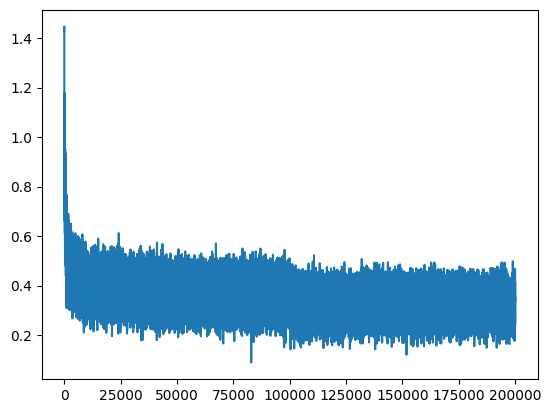

In [84]:
#plot the iteration (stepi) againts the log10 of the loss value
#remember this is done on random minibatches of 32, so it it's not a calculation of the loss on all inputs and targets at each iteration
plt.plot(stepi, lossi)

In [42]:
#now calculate the loss on the entire dataset, with no mini batches
emb = C[Xtr] # (182625, 3, 10) grab the 10 embedding values per char ID in the input (which has context length 3)
print(emb.shape)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (182625, 200) same use of view and mul as previous, but using the entire dataset
print(h.shape)
logits = h @ W2 + b2 # (32, 27) logits are the raw output of the neural net
loss = F.cross_entropy(logits, Ytr) #softmax and nll
loss #this is nll loss for the entire training dataset

torch.Size([182625, 3, 10])
torch.Size([182625, 200])


tensor(2.1287, grad_fn=<NllLossBackward0>)

In [43]:
#Xdev and Ydev are the valaidation data 
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss #the loss for the validation dataset

tensor(2.1686, grad_fn=<NllLossBackward0>)

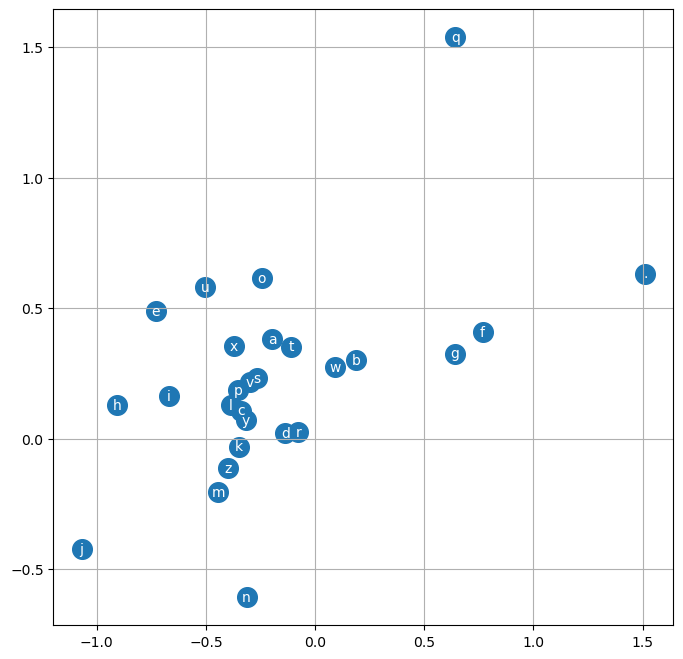

In [49]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [50]:
#C is the embedding mat which current has 10 vals per char ID
context = [0] * block_size #[0,0,0]
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [51]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 5)

for _ in range(20): #loop ofr 20 names
    
    out = []
    context = [0] * block_size # initialize with special chars ... to show start of name
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d) grab the embeddings for the 3 chars (each of size 10 in this case)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) #same process as previous
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1) #get a prob dist based on the 3 chars passed to the model
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() #sample from the prob dist to get a char
      context = context[1:] + [ix] #drop the 1st char from the context and append the new predicted char
      out.append(ix) #append the new predicted char to the out list
      if ix == 0: #if the predicted char is the special char . then this name is done and a new name can be started
        break
    
    print(''.join(itos[i] for i in out))

cari.
dylen.
ketamylia.
adraigers.
selen.
rissa.
grei.
den.
tyn.
aswaiky.
malei.
cera.
ryenni.
xeris.
illeigh.
ajestranxy.
jaisa.
motti.
briakial.
abisona.
